In [13]:
import itertools

import utils


class SectionLogger:
    def __init__(self, description):
        self.description = description

    def __enter__(self):
        print(f"### {self.description}")
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        return False  # Don't suppress exceptions

    def log(self, message):
        print(f"\t{message}")
        
def section_description(description):
    return SectionLogger(description)

In [1]:



import numpy as np
from collections import Counter
import gzip, pickle
from scipy.stats.qmc import MultivariateNormalQMC
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_folder = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"

My intention is to get the embedding model. I stole code from [here](https://github.com/CIRGLaboratory/ECXAI-2025-Stirling/blob/klaudia/provide_binary_data/2025-03-13-KBa-hierarchical-clusters.ipynb)


In [8]:
with gzip.open(f'{data_folder}\\results.pcklz', 'rb') as f:
    sequences = pickle.load(f)
    targets = pickle.load(f)
    recommendations = pickle.load(f)
    embeddings = pickle.load(f)
    target_scores = pickle.load(f)
    target_scores1 = pickle.load(f)
    target_scores2 = pickle.load(f)
    target_scores3 = pickle.load(f)

In [35]:
with section_description("What is sequences?") as section:
        
    section.log(f"It is a list of lists integers, of length {len(sequences)}")
    section.log(f"The sublists have lengths {[len(item) for item in sequences][:20]}...")
    section.log(f"The first sublist has items {sequences[0]}")

    # sequences represents the dataset, ie there are 52 000 rows
    # each row is the products that were interacted with in that session
    
    
with section_description("What is targets?") as section:
    section.log(f"Targets is a numpy array, {type(targets)}")
    section.log(targets.shape)
    
    # I'm not sure

with section_description("What is recommendations?") as section:
    section.log(recommendations.shape)
    section.log(recommendations)
    
    # for every datapoint, it shows the 100 recommendations produced by the system
    
    
with section_description("What is embeddings?") as section:
    section.log(embeddings.shape)
    # maybe it is the embedding for every item in the catalog into 64 floats?
    
    section.log(max(item for session in sequences for item in session))

### What is sequences?
	It is a list of lists integers, of length 52639
	The sublists have lengths [13, 82, 11, 37, 11, 20, 9, 4, 10, 3, 44, 5, 5, 5, 13, 72, 13, 4, 11, 14]...
	The first sublist has items [7202, 114, 5612, 27640, 15533, 194, 40433, 7540, 537, 373, 10946, 6914, 12303]
### What is targets?
	Targets is a numpy array, <class 'numpy.ndarray'>
	(52639,)
### What is recommendations?
	(52639, 100)
	[[  429   775   687 ... 24115    77  8282]
 [  421   433   687 ... 21877 10818 15010]
 [ 1371 11928   975 ...  8253  1374 28232]
 ...
 [ 1688   114 24260 ...  7782  1754 27132]
 [23909   975 24260 ...  1034   187 10864]
 [ 4938   432   684 ... 25533  5684   983]]
### What is embeddings?
	(91599, 64)
	91598


In [37]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


total_quantitity_of_items = embeddings.shape[0]

In [84]:

import os

from PolishSystem.read_data import read_cluster_info_file
cluster_quantity = 20
cluster_info_file_name = os.path.join(data_folder, f"cluster_info_{cluster_quantity}_qmc.pkl")

class CustomUnpickler(pickle.Unpickler):
    def find_class(self, module: str, name):
        # remap deprecated or changed module names
        if module.startswith("numpy._core"):
            module = module.replace("numpy._core", "numpy.core")
        return super().find_class(module, name)

def load_all_pickled_objects(file_path):
    objects = []
    with gzip.open(file_path, "rb") as f:
        unpickler = CustomUnpickler(f)
        while True:
            try:
                obj = unpickler.load()
                objects.append(obj)
            except EOFError:
                break
    return objects


contents_of_pickle = load_all_pickled_objects(cluster_info_file_name)
which_cluster, centers_embeddings, similarities, _, _, _ = contents_of_pickle



In [100]:
from Core.PS import PS
from PolishSystem.read_data import get_pRef_from_vectors, get_vectors_file_name, get_fitness_file_name

folder = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"
size = 20
method = "kmeans"
fitness_column_to_use = 0

pRef = get_pRef_from_vectors(name_of_vectors_file=get_vectors_file_name(folder, size, method),
                             name_of_fitness_file=get_fitness_file_name(folder, size, method),
                             column_in_fitness_file=fitness_column_to_use)


def get_sample_count(ps: PS):
    return len(pRef.fitnesses_of_observations(ps))

In [133]:
import random
from Core.PRef import PRef
import math




class PSSampler:
    def __init__(self):
        pass
    
    def sample(self) -> PS:
        raise NotImplementedError()


class PSSamplerByQuantity(PSSampler):
    average_items_per_session: int
    n: int
    
    def __init__(self,
                 pRef: PRef):
        self.average_items_per_session = math.floor(np.average(np.sum(pRef.full_solution_matrix, axis=1)))
        self.n = pRef.search_space.amount_of_parameters
        super().__init__()
    
    def sample(self) -> PS:
        result_values = np.zeros(self.n, dtype=int)
        indices_to_set = [random.randrange(self.n) for _ in range(self.average_items_per_session)]
        result_values[indices_to_set] = 1
        return PS(result_values)
    


class PSSamplerByProbability(PSSampler):
    n: int
    probabilties: np.ndarray
    
    
    def __init__(self,
                 pRef: PRef):
        self.n = pRef.search_space.amount_of_parameters
        self.probabilities = np.average(pRef.full_solution_matrix, axis=0)
        self.probabilities /= sum(self.probabilities) # the expected quantity of ones is 2
        self.probabilities *= 2
        
        super().__init__()
    
    def sample(self) -> PS:
        return PS(np.random.random(self.n)<self.probabilities)


samplers = [PSSamplerByQuantity(pRef),
            PSSamplerByProbability(pRef)]

generality_of_samplers = []
for sampler in samplers:
    samples = [get_sample_count(sampler.sample()) for _ in range(200)]
    print(np.median(samples))
        

5.0
22.0


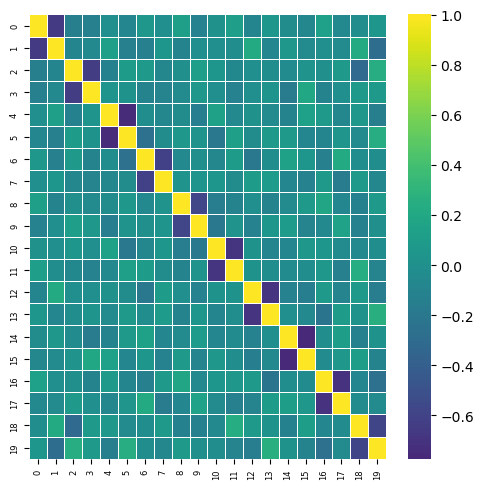

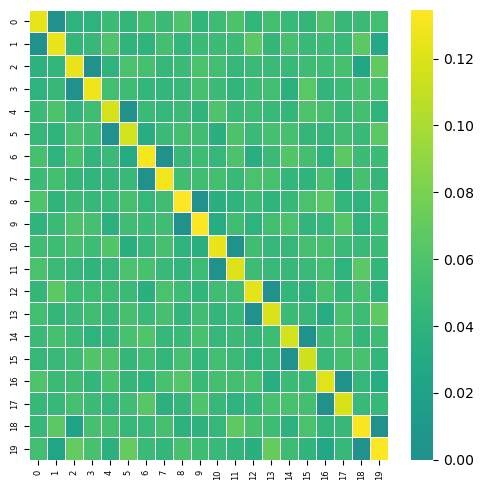

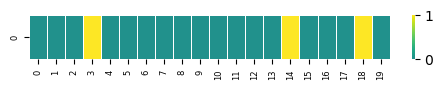

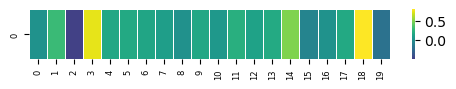

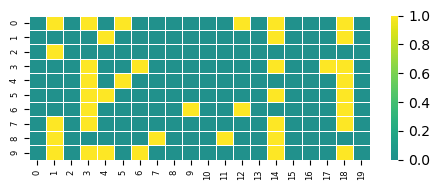

In [169]:
utils.show_matrix_with_colours(similarities, fig_size=(5, 5))

def normalise_vector(vector):
    m = np.min(vector)
    M = np.max(vector)
    return (vector-m) / (M-m)
def normalise_every_row(table):
    return np.array([normalise_vector(row) for row in table])

transition_matrix = normalise_every_row(similarities)

transition_matrix = np.array([row / np.sum(row) for row in transition_matrix])
utils.show_matrix_with_colours(transition_matrix, fig_size=(5, 5))



random_PS = samplers[0].sample().values
ps_matrix = random_PS.reshape((1, -1))
utils.show_matrix_with_colours(ps_matrix, fig_size=(5, 1))

expected = ps_matrix @ transition_matrix



expected = expected.reshape(-1)
expected /= np.sum(expected)

wanted_sum = np.sum(random_PS)
wanted_max = 0.8
current_max = np.max(expected)

a_num = wanted_max * cluster_quantity - wanted_sum
b_num = current_max * wanted_sum - wanted_max
expected = (expected * a_num + b_num) / (current_max * cluster_quantity - 1)

utils.show_matrix_with_colours(expected.reshape((1, -1)), fig_size=(5, 1))

def get_from_expected():
    return np.random.random(cluster_quantity) < expected


results = np.array([get_from_expected() for _ in range(10)])
utils.show_matrix_with_colours(results, fig_size=(4.75, 2))

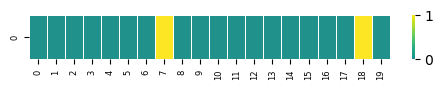

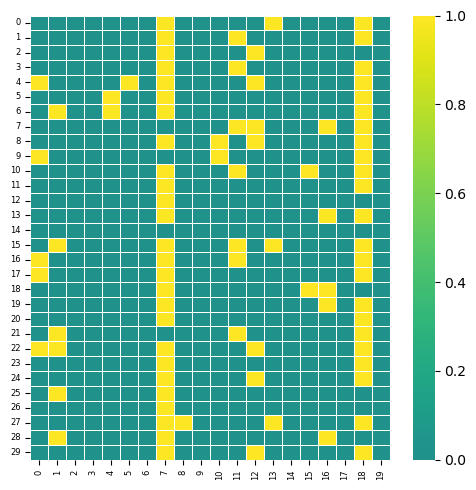

In [219]:
def get_transition_matrix(similarities):
        def normalise_vector(vector):
            m = np.min(vector)
            M = np.max(vector)
            return (vector-m) / (M-m)
        def normalise_every_row(table):
            return np.array([normalise_vector(row) for row in table])
        
        transition_matrix = normalise_every_row(similarities)
        
        transition_matrix = np.array([row / np.sum(row) for row in transition_matrix])
        return transition_matrix

def scale_to_have_sum_and_max(vec: np.ndarray, wanted_sum, wanted_max, positions: int):
    with_sum_one = vec / np.sum(vec) 
    current_max = np.max(with_sum_one)
    # current sum = 1
    n = positions
    
    a_num = wanted_max * n - wanted_sum
    b_num = current_max * wanted_sum - wanted_max
    denom = current_max * n - 1
    
    result = (with_sum_one * a_num + b_num) / denom
    
    return result

class MutationUsingSimilarities:
    disappearance_rate: float
    transition_matrix: np.ndarray
    n: int
    
    def __init__(self, similarities: np.ndarray,
                 mutation_rate: float):
        self.transition_matrix = get_transition_matrix(similarities)
        self.n = similarities.shape[0]
        self.disappearance_rate = 1-mutation_rate
        
    def mutate(self, ps: PS):
        values = ps.values
        # step 1: obtain probabilties from the transition matrix (as if it was a markov model)
        unscaled_probabilities = (values.reshape((1, -1)) @ transition_matrix).reshape(-1)
        
        # step 2: scale the probabilities so that
        ## * the expected quantity of ones at the end is probably the same as the original (wanted sum)
        ## * the probability of the original values staying is wanted_max
        
        probabilities = scale_to_have_sum_and_max(unscaled_probabilities, wanted_sum=np.sum(values), wanted_max=self.disappearance_rate, positions = self.n)
        # step 3: generate a solution based on those probabilities
        return PS(np.random.random(self.n) < probabilities)
    
    
mutation_operator = MutationUsingSimilarities(similarities, mutation_rate=0.2)
starting_point = samplers[0].sample()
mutations = [mutation_operator.mutate(starting_point) for _ in range(30)]

utils.show_matrix_with_colours(starting_point.values.reshape((1, -1)), fig_size=(5, 1))
utils.show_matrix_with_colours(np.array([mut.values for mut in mutations]), fig_size=(5, 5))
        


The mother is [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0])
The father is [0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0])


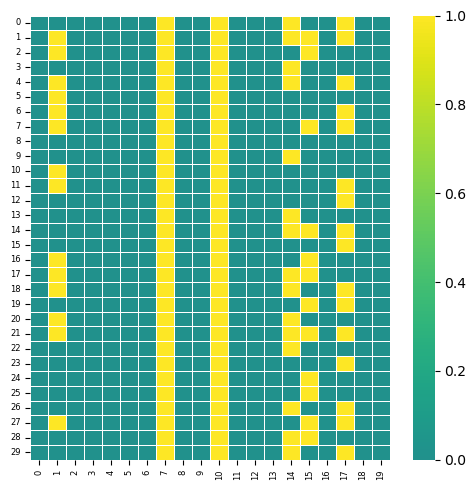

In [222]:
# crossover

class CrossoverOperator:
    transition_matrix: np.ndarray
    n: int
    
    def __init__(self, similarities: np.ndarray):
        self.transition_matrix = get_transition_matrix(similarities)
        self.n = similarities.shape[0]

    def crossover(self, mother: PS, father: PS):
        m_values, f_values = mother.values, father.values
        guaranteed = m_values * f_values
        considering = m_values + f_values - guaranteed * 2
        
        guaranteed = np.array(guaranteed, dtype=bool)
        considering = np.array(considering, dtype=bool)
        
        probabilities_for_considering = (considering.reshape((1, -1)) @ transition_matrix).ravel()
        probabilities_for_considering[~considering] = 0
        
        average_cardinality = (np.sum(m_values) + np.sum(f_values))/2 - np.sum(guaranteed)
        actual_probabilities = scale_to_have_sum_and_max(probabilities_for_considering, wanted_sum=average_cardinality, wanted_max=0.5, positions = len(considering))
        actual_probabilities[~considering] = 0
        actual_probabilities[guaranteed] = 1
        
        return PS(np.random.random(20) < actual_probabilities)
    
    
crossover_operator = CrossoverOperator(similarities)

mother= samplers[0].sample()
father = mutation_operator.mutate(mother)

print(f"The mother is {mother})")
print(f"The father is {father})")


children = [crossover_operator.crossover(mother, father) for _ in range(30)]

utils.show_matrix_with_colours(np.array([mut.values for mut in children]), fig_size=(5, 5))